In [218]:
import numpy as np
import matplotlib.pyplot as plt
from random import normalvariate
from math import sqrt
from numpy.linalg import norm
from PIL import Image
import os

In [219]:
#The compressed file will be 1/N as big as the original
N = 5; 

Randomized SVD implementation

In [220]:
def random_svd(A, rank=200, n_oversamples=None, n_subspace_iters=None):
    """
    Randomized SVD (p. 227 of Halko et al).
    """
    n_samples = 2 * rank if n_oversamples is None else rank + n_oversamples

    Q = find_range(A, n_samples, n_subspace_iters)

    B = Q.T @ A
    U_tilde, S, Vt = np.linalg.svd(B)
    U = Q @ U_tilde

    return U, S, Vt

def find_range(A, n_samples, n_subspace_iters=None):
    """
    Algorithm 4.1: Randomized range finder (p. 240 of Halko et al).
    """
    m, n = A.shape
    O = np.random.randn(n, n_samples)
    Y = A @ O

    return subspace_iter(A, Y, n_subspace_iters) if n_subspace_iters else orthonormal_basis(Y)

def subspace_iter(A, Y0, n_iters):
    """
    Algorithm 4.4: Randomized subspace iteration (p. 244 of Halko et al).
    """
    Q = orthonormal_basis(Y0)
    
    for _ in range(n_iters):
        Z = orthonormal_basis(A.T @ Q)
        Q = orthonormal_basis(A @ Z)

    return Q

def orthonormal_basis(M):
    Q, _ = np.linalg.qr(M)
    return Q

Power method svd implementation

In [221]:
def random_unit_vector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    the_norm = sqrt(sum(x * x for x in unnormalized))
    return [x / the_norm for x in unnormalized]


def svd_1d(A, eps=0.01):
    ''' The one-dimensional SVD '''
    n, m = A.shape
    x = random_unit_vector(min(n,m))
    last_V = None
    current_V = x
    iterations = 0
    B = A.T @ A if n > m else A @ A.T

    while True:
        iterations += 1
        last_V = current_V
        current_V = B @ last_V
        current_V = current_V / norm(current_V)

        if abs(np.dot(current_V, last_V)) > 1 - eps:
            return current_V


def power_method_svd(A, k=None, epsilon=0.01):
    A = np.array(A, dtype=float)
    n, m = A.shape
    svd_so_far = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrix_for_1D = A.copy()

        for singular_value, u, v in svd_so_far[:i]:
            matrix_for_1D -= singular_value * np.outer(u, v)

        if n > m:
            v = svd_1d(matrix_for_1D, eps = epsilon)  # next singular vector 
            u_unnormalized = A @ v
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrix_for_1D, eps = epsilon)  # next singular vector
            v_unnormalized = A.T @ u
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svd_so_far.append((sigma, u, v))

    singular_values, us, vs = [np.array(x) for x in zip(*svd_so_far)]
    return us.T, singular_values, vs


In [222]:
image = Image.open('landscape_640x426.bmp') 
original_image_size = os.path.getsize('landscape_640x426.bmp')
image = np.array(image) 

red_channel = image[:,:,0]
green_channel = image[:,:,1]
blue_channel = image[:,:,2]

# Variables to hold svd matrices for each color channel
red_svd_u, red_svd_s, red_svd = 0,0,0
green_svd_u, green_svd_s, green_svd = 0,0,0 
blue_svd_u, blue_svd_s, blue_svd = 0,0,0

def calculate_svd_for_each_channel(svd_implementation):
    global red_svd_u, red_svd_s, red_svd, green_svd_u, green_svd_s, green_svd, blue_svd_u, blue_svd_s, blue_svd
    red_svd_u, red_svd_s, red_svd = svd_implementation(red_channel)
    green_svd_u, green_svd_s, green_svd = svd_implementation(green_channel)
    blue_svd_u, blue_svd_s, blue_svd = svd_implementation(blue_channel)
    

# Perform SVD compression on one color channel
def compress_colors(k):
    return [red_svd_u[:, :k], np.diag(red_svd_s[:k]), red_svd[:k, :],
            green_svd_u[:, :k], np.diag(green_svd_s[:k]), green_svd[:k, :],
            blue_svd_u[:, :k], np.diag(blue_svd_s[:k]), blue_svd[:k, :]]

# Takes an image converted to numpy array
def compress_the_whole_image(k):
    mat_array = compress_colors(k)
    np.savez_compressed('compressed.npz',
                        U_red = mat_array[0], S_red = mat_array[1].diagonal(), V_red = mat_array[2],
                        U_green = mat_array[3], S_green = mat_array[4].diagonal(), V_green = mat_array[5],
                        U_blue = mat_array[6], S_blue = mat_array[7].diagonal(), V_blue = mat_array[8], k=[k])

def restore_image(path_to_file):
    intermediate_representation = np.load('compressed.npz')

    k = intermediate_representation['k'][0]
    U_red = intermediate_representation['U_red']
    S_red = np.diag(intermediate_representation['S_red'])
    V_red = intermediate_representation['V_red']
    U_green = intermediate_representation['U_green']
    S_green = np.diag(intermediate_representation['S_green'])
    V_green = intermediate_representation['V_green']
    U_blue = intermediate_representation['U_blue']
    S_blue = np.diag(intermediate_representation['S_blue'])
    V_blue = intermediate_representation['V_blue']

    
    return [np.stack((U_red @ S_red @ V_red, U_green @ S_green @ V_green, U_blue @ S_blue @ V_blue), axis=-1), k]

calculate_svd_for_each_channel(np.linalg.svd)
# Number of singular values
k = 100
compress_the_whole_image(k)
while((original_image_size/(os.path.getsize('compressed.npz'))) <= N):
    k -= 1
    compress_the_whole_image(k) 

Restoring compressed image from the file & comparing it to the original

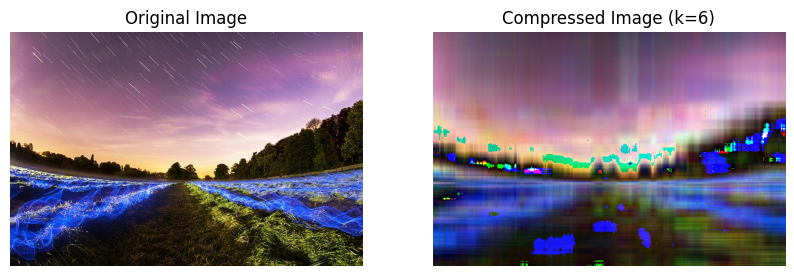

In [223]:
# image + k
image_restoration_result = restore_image("compressed.npz")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(image_restoration_result[0].astype(np.uint8))
axs[1].set_title(f'Compressed Image (k={image_restoration_result[1]})') 

for ax in axs:
    ax.axis('off')

plt.show()